# <a id='toc1_'></a>[Trading Strategy](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Trading Strategy](#toc1_)    
- [Import libraries](#toc2_)    
- [Import data](#toc3_)    
- [10-1 portfolio](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Import libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

from pathlib import Path
import sys
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))
from libs.functions import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

# <a id='toc3_'></a>[Import data](#toc0_)

In [2]:
preds = pd.read_csv('data/predictions.csv')
preds.rename(columns={'Unnamed: 0': 'index_original'}, inplace=True)
preds.columns = preds.columns.str.lower()
preds['timestamp'] = pd.to_datetime(preds['timestamp']) + pd.offsets.MonthEnd(1) # add one month as the target is the prediction for the next month
# preds['y_true'] = preds['y_true'] + ((1+preds['discount'])**(1/12)-1) # add back the short rate to get the true return

data_raw = pd.read_csv('data/data.csv')
discount = data_raw[['timestamp', 'discount']].copy()
discount['timestamp'] = pd.to_datetime(discount['timestamp'])
discount['discount_m'] = (1 + discount['discount'])**(1/12) - 1

omxc25_tickers = pd.read_csv('data/omxc25_constit.csv')
omxc25_tickers = omxc25_tickers[['timestamp', 'ticker']]
omxc25_tickers['in_c25'] = True
omxc25_tickers['timestamp'] = pd.to_datetime(omxc25_tickers['timestamp'])

omxc25_price = pd.read_csv('data/omxc25_price.csv')
omxc25_price['timestamp'] = pd.to_datetime(omxc25_price['timestamp'])
omxc25_price = omxc25_price[(omxc25_price['timestamp'] >= '2021-01-01') & (omxc25_price['timestamp'] <= '2024-12-31')]

omxcb_tickers = pd.read_csv('data/omxcb_constit.csv')
omxcb_tickers = omxcb_tickers[['timestamp', 'ticker']]
omxcb_tickers['timestamp'] = pd.to_datetime(omxcb_tickers['timestamp'])
omxcb_tickers['in_cb'] = True 

omxcb_price = pd.read_csv('data/omxcb_price.csv')
omxcb_price['timestamp'] = pd.to_datetime(omxcb_price['timestamp'])
omxcb_price = omxcb_price[(omxcb_price['timestamp'] >= '2021-01-01') & (omxcb_price['timestamp'] <= '2024-12-31')]

In [3]:
df = (preds
      .merge(omxc25_tickers, on=['ticker','timestamp'], how='left')
      .merge(omxcb_tickers, on=['ticker','timestamp'], how='left')
)
df['in_c25'] = np.where(df['in_c25'].isna(), False, df['in_c25'])
df['in_cb'] = np.where(df['in_cb'].isna(), False, df['in_cb'])

df = df[df['in_cb'] == True]
df = df[df['in_c25'] == True]

# <a id='toc4_'></a>[N-1 portfolio](#toc0_)

In [4]:
# calculate portfolio returns
df.sort_values(by=['timestamp'])
port_10_1 = pd.DataFrame()
models = ['ols','lasso','mlp','mlp-pyr']
n_deciles = 5

for model in models:
    for dir in ['long', 'short']:
        tmp = df.copy(deep=True)
        tmp = tmp[['timestamp', model, 'y_true']]
        tmp['decile'] = df.groupby(['timestamp'])[model].transform(lambda x: pd.qcut(x, n_deciles, labels=False))
        # create action column based on decile
        if dir == 'long':
            tmp['action'] = np.where(tmp['decile'] == n_deciles-1, 1, 0)
        else:
            tmp['action'] = np.where(tmp['decile'] == 0, -1, 0)
        # find stocks in position
        tmp[f'n_dir'] = (tmp['action'] == (1 if dir == 'long' else -1)).astype(int)
        tmp[f'n_dir'] = tmp.groupby('timestamp')[f'n_dir'].transform('sum')
        
        # calculate return for the direction (equal weighted)  
        tmp[f'{model}_{dir}'] = tmp['action']*tmp['y_true']/tmp[f'n_dir'] # multiply by action to get the return for the direction

        # sum the returns for each month
        tmp = tmp.groupby('timestamp')[f'{model}_{dir}'].sum().reset_index()
        # calculate cumulative return and percentage return
        tmp[f'{model}_{dir}'] = tmp[f'{model}_{dir}'] + 1
        tmp[f'{model}_{dir}_cum'] = tmp[f'{model}_{dir}'].cumprod() * 100
        tmp[f'{model}_{dir}'] = tmp[f'{model}_{dir}'] - 1

        port_10_1 = pd.concat([port_10_1, tmp], axis=1)
port_10_1 = port_10_1.loc[:, ~port_10_1.columns.duplicated()]

# start with an initial value of 100
port_10_1.loc[-1] = [pd.Timestamp('2021-01-01'), np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100, np.nan, 100]
port_10_1 = port_10_1.sort_index().reset_index(drop=True)


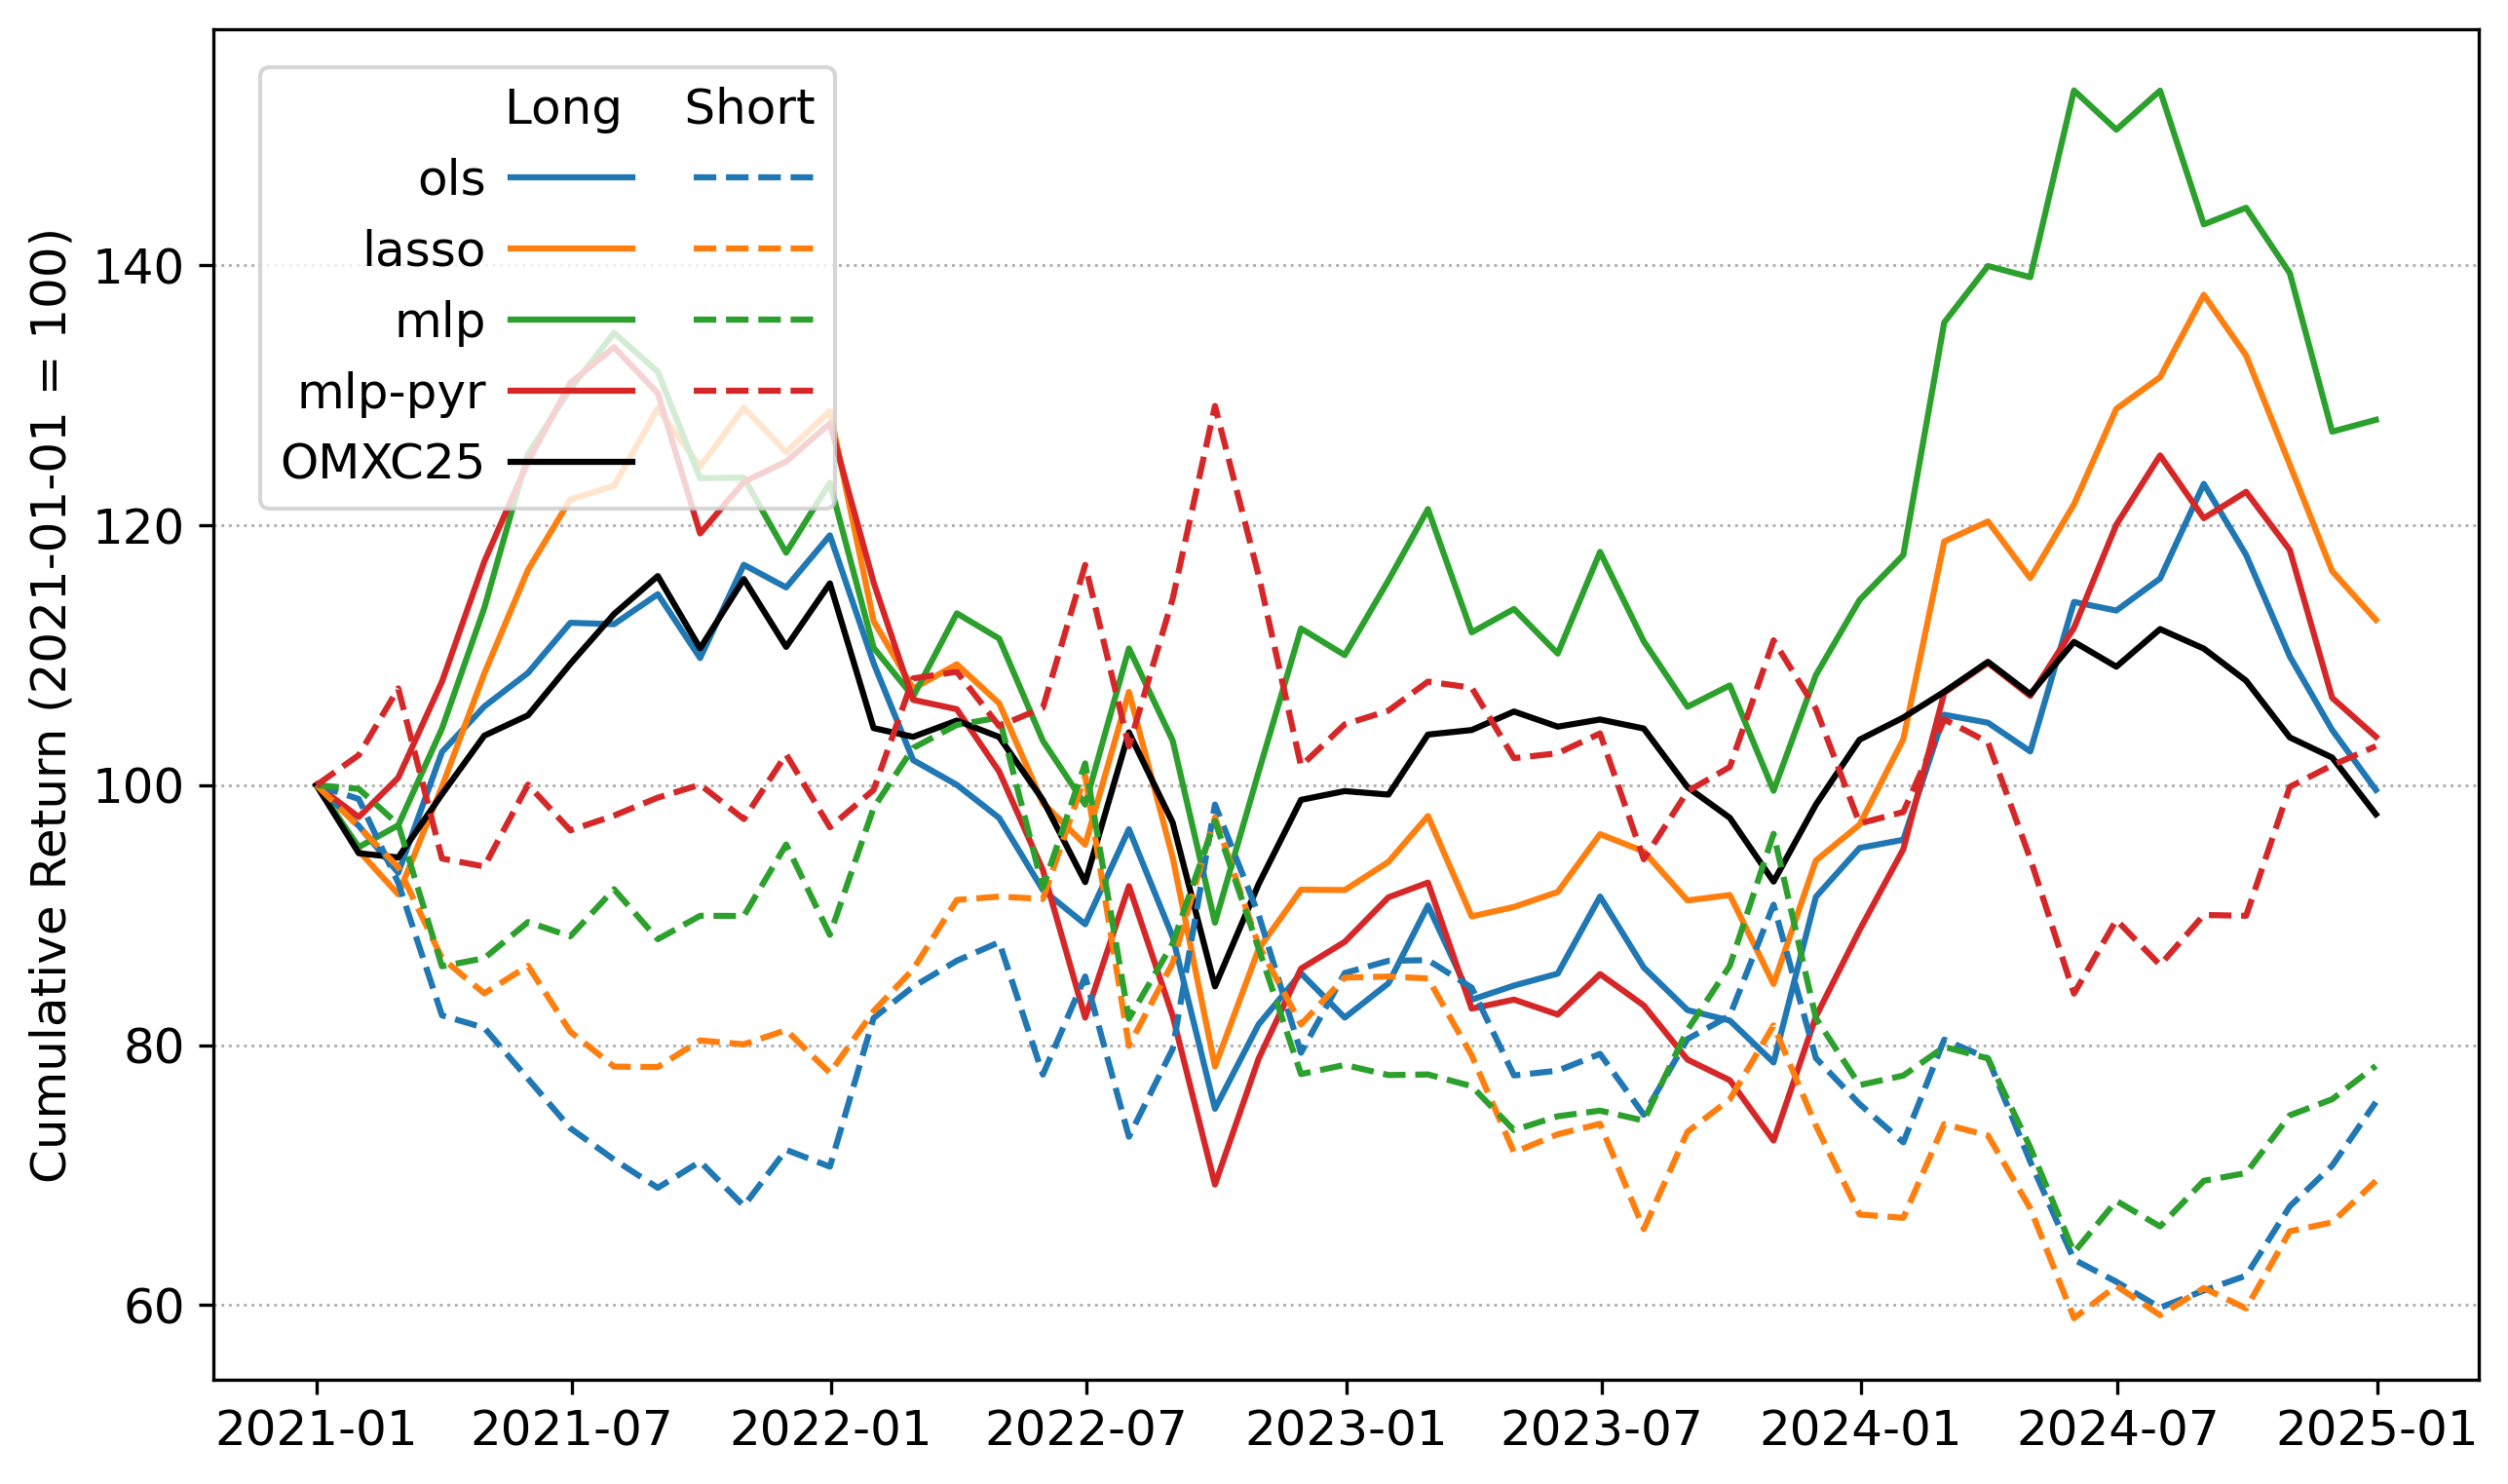

In [5]:
# plotting
fig, ax = plt.subplots(figsize=(10, 6))
default_cycler = plt.rcParams['axes.prop_cycle']
for model in models:    
    ax.plot(port_10_1['timestamp'], port_10_1[f'{model}_long_cum'], label=f'{model}', linestyle='-')
ax.plot(omxc25_price['timestamp'], omxc25_price['cumulative'], label='OMXC25', linestyle='-', color='black')
ax = plt.gca()
ax.set_prop_cycle(default_cycler)
for model in models:    
    ax.plot(port_10_1['timestamp'], port_10_1[f'{model}_short_cum'], label=f' ', linestyle='--')
ax.set_ylabel('Cumulative Return (2021-01-01 = 100)')
ax.yaxis.grid(True, which='major', linestyle=':', linewidth=0.7)

leg = ax.legend(ncol=2, loc='upper left',frameon=True, markerfirst=False, handlelength=2.5,handletextpad=0.5, bbox_to_anchor=(0.01, 0.99, 0.275 ,0.0), mode='expand', title='Long    Short')
leg._legend_box.align = "right"

plt.savefig('figs/port10-1_return.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
asset_ret = (
    preds
    .pivot_table(
        index='timestamp',
        columns='ticker',
        values='y_true',
        aggfunc='mean'
    )
    .fillna(0)
)

preds['timestamp'] = pd.to_datetime(preds['timestamp'])
preds = preds.sort_values('timestamp')
for m in models:
    preds[f'dec_{m}'] = assign_decile(preds, m, n_deciles)

tbl_panel = {}
for m in models:
    dec_r = (
        preds
        .groupby(['timestamp', f'dec_{m}'])['y_true']
        .mean()
        .unstack(f'dec_{m}')
        .sort_index()
    )
    dec_p = (
        preds
        .groupby(['timestamp', f'dec_{m}'])[m]
        .mean()
        .unstack(f'dec_{m}')
        .sort_index()
    )

    records = []
    for d in range(1, n_deciles+1):
        r_ts = dec_r[d]
        p_ts = dec_p[d]
        avg = r_ts.mean()
        sd  = r_ts.std(ddof=1)
        sr  = avg/sd * np.sqrt(12)
        p   = p_ts.mean()
        records.append({'decile':d, 'Pred':p, 'Avg':avg, 'SD':sd, 'SR':sr})

    # now H–L synthetic series
    r_hl = dec_r[n_deciles] - dec_r[1]
    p_hl = dec_p[n_deciles] - dec_p[1]
    avg = r_hl.mean()
    sd  = r_hl.std(ddof=1)
    sr  = avg/sd * np.sqrt(12)
    p   = p_hl.mean()
    records.append({'decile':'H-L','Pred':p,'Avg':avg,'SD':sd,'SR':sr})

    df_panel = pd.DataFrame(records).set_index('decile')
    tbl_panel[m] = df_panel
    tbl_panel[m].rename(index={1: 'Low (L)'}, inplace=True)
    tbl_panel[m].rename(index={n_deciles: 'High (H)'}, inplace=True)

In [ ]:
model_groups = [['ols','lasso'], ['mlp','mlp-pyr']]
tab = portfolio_panel(tbl_panel, model_groups)

with open('tabs/portfolio_table.tex', 'w') as f:
    f.write(tab)

\begin{tabular}{lrrrrrrrr}
\hline \hline \\ [-1.8ex]
 & \multicolumn{4}{c}{ols} & \multicolumn{4}{c}{lasso} \\
 \cmidrule(lr){2-5} \cmidrule(lr){6-9}
Decile & Pred & Avg & SD & SR & Pred & Avg & SD & SR \\
\midrule
Low (L) & -0.035 & 0.003 & 0.079 & 0.123 & -0.016 & 0.005 & 0.070 & 0.249 \\
2 & -0.013 & -0.002 & 0.063 & -0.120 & -0.004 & -0.001 & 0.065 & -0.040 \\
3 & -0.000 & 0.006 & 0.054 & 0.364 & 0.004 & -0.004 & 0.052 & -0.267 \\
4 & 0.013 & 0.007 & 0.064 & 0.394 & 0.011 & 0.011 & 0.060 & 0.619 \\
High (H) & 0.036 & 0.002 & 0.062 & 0.099 & 0.025 & 0.005 & 0.067 & 0.244 \\
H-L & 0.071 & -0.001 & 0.065 & -0.055 & 0.041 & -0.000 & 0.071 & -0.017 \\
\midrule
 & \multicolumn{4}{c}{mlp} & \multicolumn{4}{c}{mlp-pyr} \\
 \cmidrule(lr){2-5} \cmidrule(lr){6-9}
Decile & Pred & Avg & SD & SR & Pred & Avg & SD & SR \\
\midrule
Low (L) & 0.001 & 0.003 & 0.070 & 0.125 & -0.003 & -0.003 & 0.065 & -0.145 \\
2 & 0.004 & -0.003 & 0.048 & -0.197 & 0.004 & 0.009 & 0.056 & 0.566 \\
3 & 0.006 & 0.003 &

In [15]:
# Drawdowns and turnover
tbl8 = {}
for m in models:
    # build VW returns for deciles
    vw = {}
    for d in [1, n_deciles]:
        grp = preds[preds[f'dec_{m}'] == d]
        w_raw = grp['y_true'].abs()
        w = w_raw / w_raw.sum()
        vw[d] = (w * grp['y_true']).groupby(grp['timestamp']).sum().sort_index()

    stats = {}
    for label, series in [('Low', vw[1]), ('High', vw[n_deciles])]:
        d = 1 if label == 'Low' else n_deciles
        weights_df = (
            preds[preds[f'dec_{m}'] == d]
            .pivot_table(index='timestamp', columns='ticker',
                         values='y_true', aggfunc='mean')
            .abs()
        )
        weights_df = weights_df.div(weights_df.sum(axis=1), axis=0)
        stats[label] = {
            'Max DD (%)':      100 * max_drawdown(series),
            'Max 1M loss (%)': -100 * series.min(),
            'Turnover (%)':    turnover_exact(weights_df, asset_ret)
        }
    tbl8[m] = pd.DataFrame(stats)


In [16]:
for m in models:
    print(f"\n=== Model: {m} ===")
    print("\nTable 8:")
    print(tbl8[m].round(4))


=== Model: ols ===

Table 8:
                     Low     High
Max DD (%)        1.8781   1.5554
Max 1M loss (%)   1.4930   0.6693
Turnover (%)     28.8958  25.2547

=== Model: lasso ===

Table 8:
                     Low     High
Max DD (%)        1.0207   1.9779
Max 1M loss (%)   0.7184   0.8498
Turnover (%)     26.1322  28.2201

=== Model: mlp ===

Table 8:
                     Low     High
Max DD (%)        1.0851   1.5159
Max 1M loss (%)   0.5626   0.6475
Turnover (%)     29.9060  24.4131

=== Model: mlp-pyr ===

Table 8:
                     Low     High
Max DD (%)        2.4321   2.4060
Max 1M loss (%)   0.7140   0.7370
Turnover (%)     28.1873  24.9299


# Sign-only

In [11]:
port_directional = pd.DataFrame()

for model in models:
    tmp = df.copy(deep=True)
    tmp['action'] = np.where(np.sign(tmp[model]) == 1, 1, np.where(np.sign(tmp[model]) == -1, -1, 0))
    tmp['action'] = np.where(np.sign(tmp[model]) == 1, 1, -1)

    tmp['n_short'] = (tmp['action'] == -1).astype(int)
    tmp['n_long'] = (tmp['action'] == 1).astype(int)

    tmp['n_short'] = tmp.groupby('timestamp')['n_short'].transform('sum')
    tmp['n_long'] = tmp.groupby('timestamp')['n_long'].transform('sum')


    tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true']/tmp['n_long'],
                        np.where(tmp['action'] == -1, - tmp['y_true']/tmp['n_short'], 0))
    # pure one directional strategy
    # tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true']/tmp['n_long'],0)
    # tmp[f'{model}_return'] = np.where(tmp['action'] == -1, - tmp['y_true']/tmp['n_short'],0)

    tmp = tmp.groupby('timestamp')[f'{model}_return'].sum().reset_index()
    tmp[f'{model}_return'] = tmp[f'{model}_return'] + 1
    tmp[f'{model}_return_cum'] = tmp[f'{model}_return'].cumprod() * 100
    tmp[f'{model}_return'] = tmp[f'{model}_return'] - 1
    
    port_directional = pd.concat([port_directional, tmp], axis=1)
port_directional = port_directional.loc[:, ~port_directional.columns.duplicated()]
port_directional.loc[-1] = [pd.Timestamp('2021-01-01'), 0, 100, 0, 100, 0, 100, 0, 100]
port_directional = port_directional.sort_index().reset_index(drop=True)

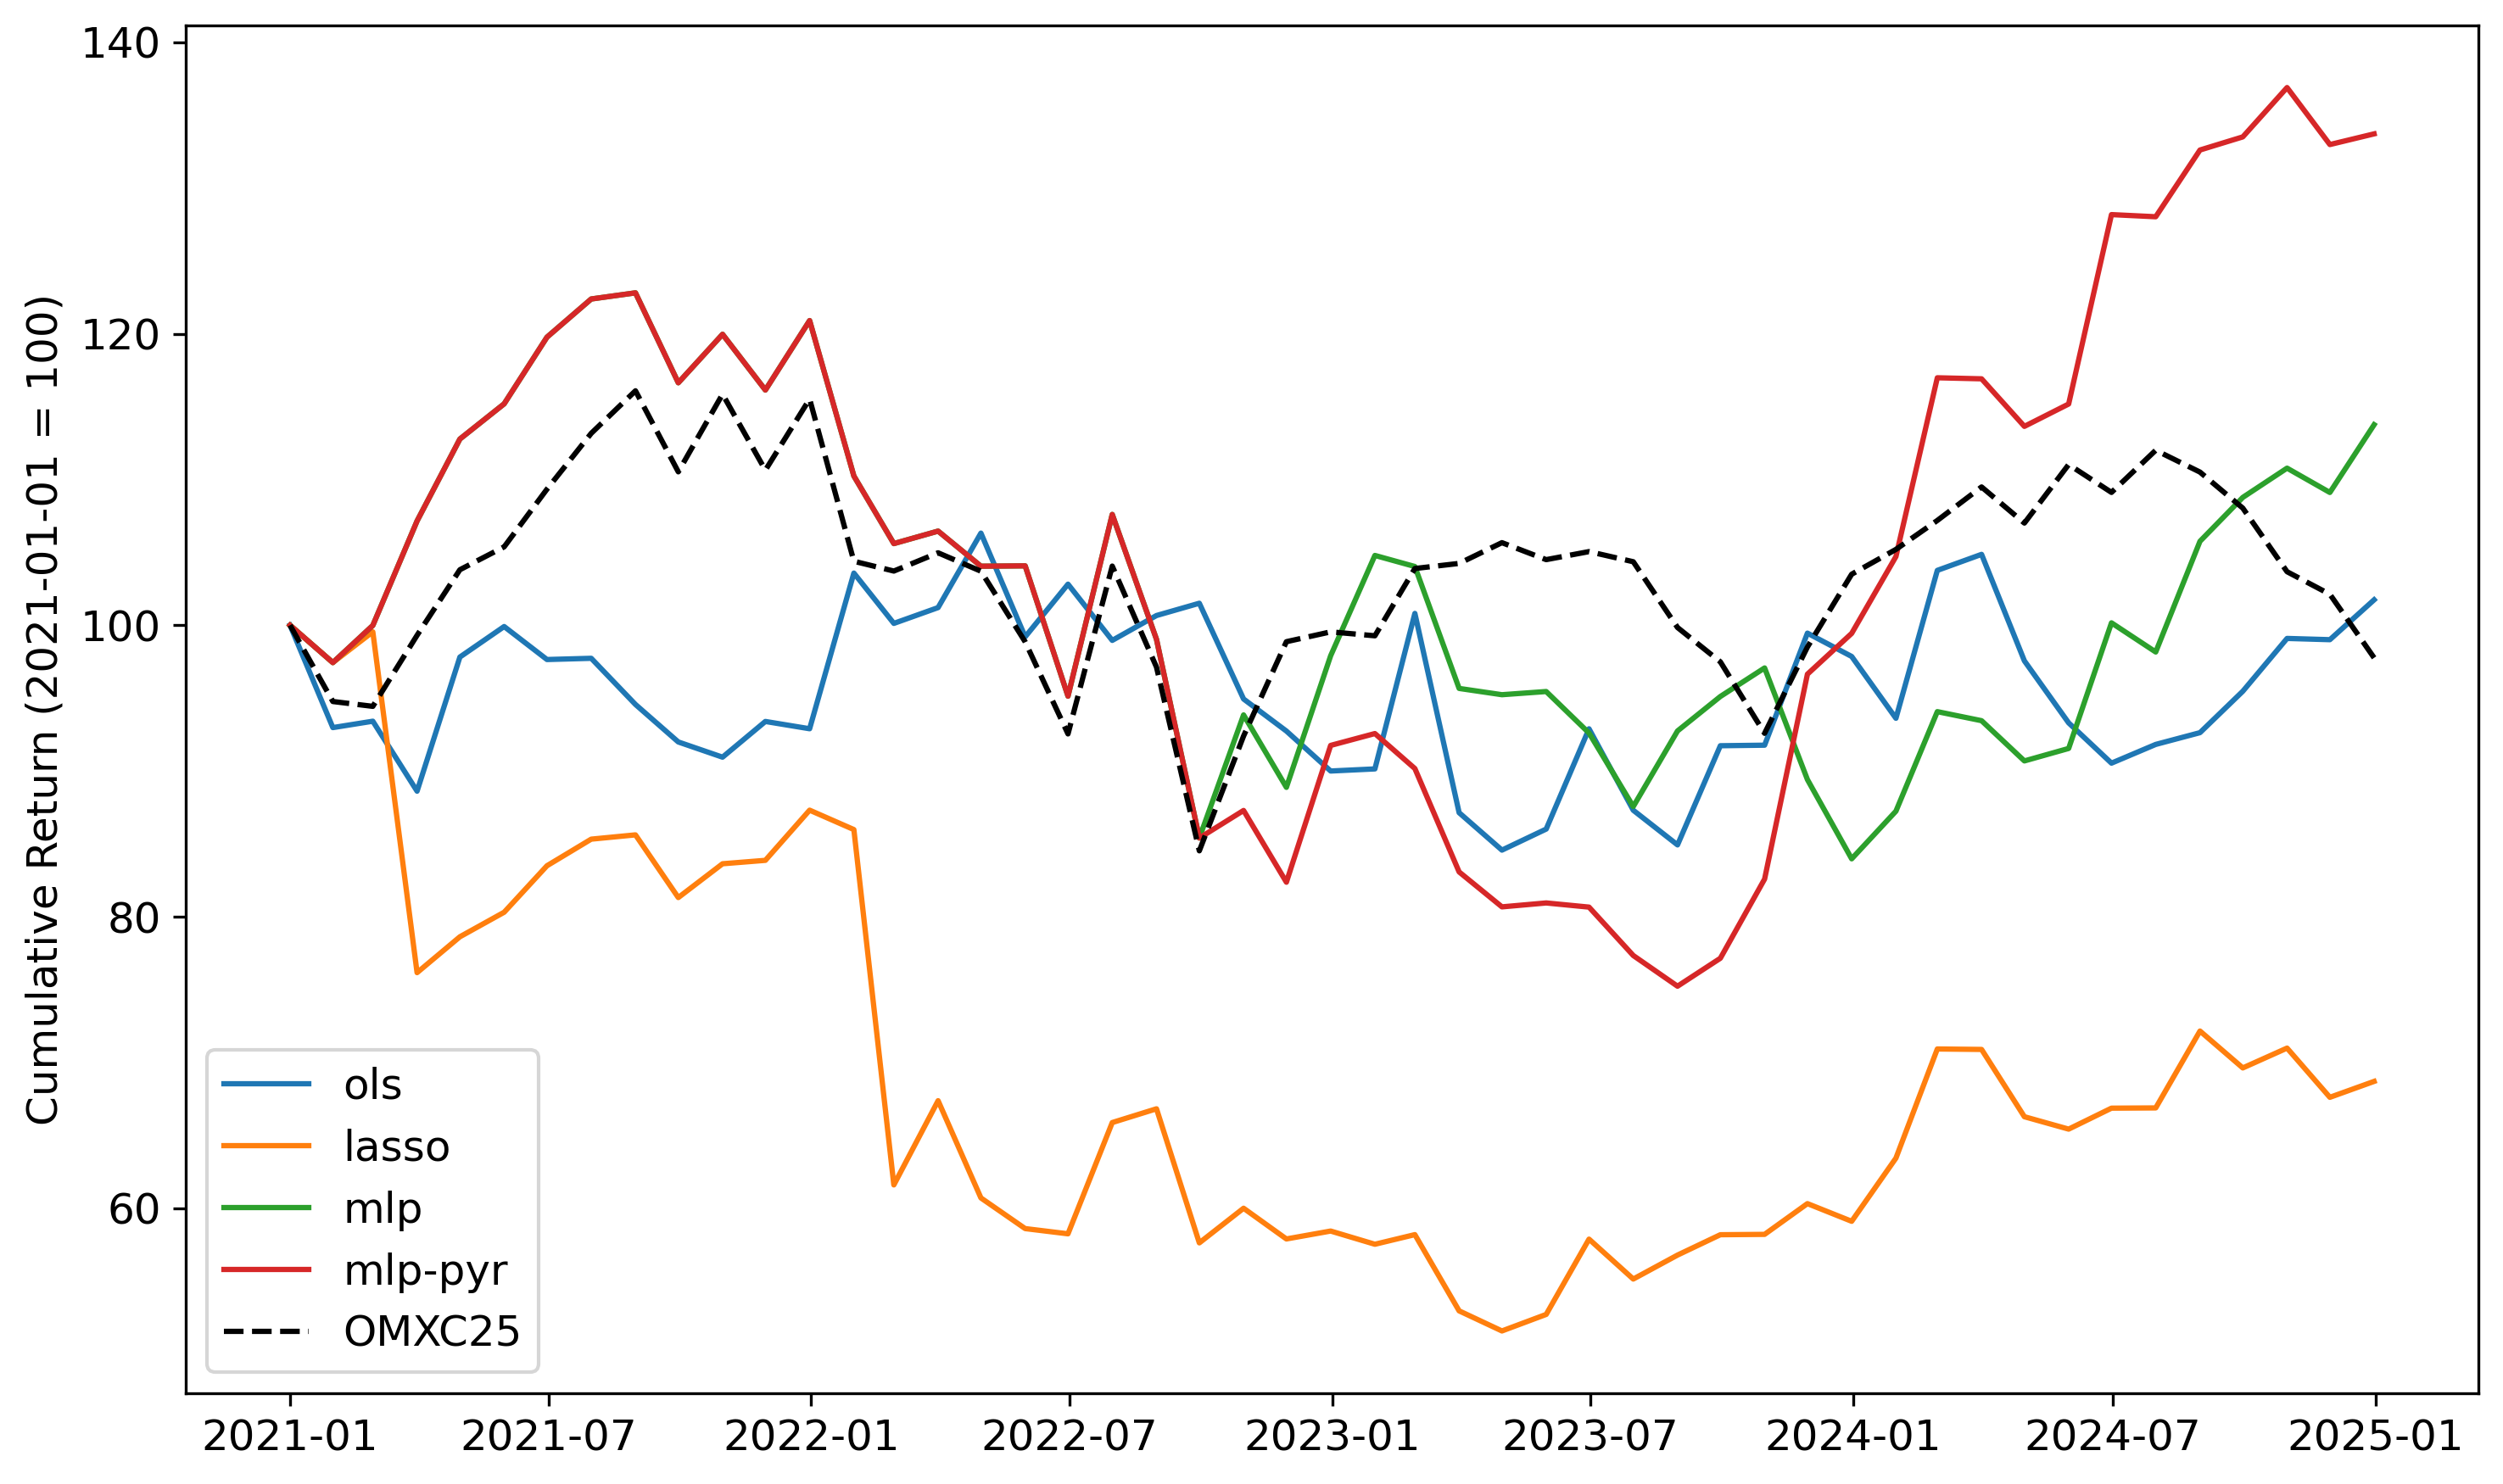

In [12]:
# plotting
plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(port_directional['timestamp'], port_directional[f'{model}_return_cum'], label=model)
plt.plot(omxc25_price['timestamp'], omxc25_price['cumulative'], label='OMXC25', linestyle='--', color='black')
# plt.plot(omxcb_price['timestamp'], omxcb_price['cumulative'], label='OMXCB', linestyle='--')
# plt.title('Cumulative Returns by Model')
# plt.xlabel('Timestamp')
plt.ylabel('Cumulative Return (2021-01-01 = 100)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()